## JMPY  
Jmpy is an analysis library created to simplify common plotting and modeling tasks.  Simplicity, a common plotting signature, and ease of use are preferred over flexibility.

The goal is to create mini-reports with each function for better visualization of data.
___
Currently, there are three modules:  plotting, modeling, and bayes.  
Plotting is used to make pretty graphs, and modeling is used to anaylyze data with visual output.  
Bayes is currenlty in development to support easy bayesian analysis and plotting, relying on significant assumptions about the underlaying data.

This module relies heavily on statsmodels, patsy, pymc, and pandas.

___
__Overview__  
[Plotting](#plotting)  
* [Histogram](#histogram)  
* [Cumprob](#cumprob)  
* [Boxplot](#boxplot)
* [ScatterPlot](#scatter)
* [Contour](#contour)

[Grid Layout](#grid)  
[Modeling](#modeling)  
[Bayes](#bayes)  

In [1]:
%load_ext autoreload
%autoreload 2
    
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

import jmpy.plotting as jp
import jmpy.modeling as jm
import jmpy.bayes as jb

import warnings
warnings.filterwarnings('ignore')

<a id='plotting'></a>
### Plotting  
___
Create some artifical data for our analysis:

In [2]:
nsamples = 250
xc = np.linspace(0, 100, nsamples)
xc2 = xc**2
xd = np.random.choice([1, 3, 5, 7], nsamples)
xe = np.random.choice([10, 30, 50], nsamples)
xf = np.random.choice([.1, .4], nsamples)
xg = np.random.normal(size=nsamples)*15

X = np.column_stack((xc, xc2, xd, xe))
beta = np.array([1, .01, 17, .001])

e = np.random.normal(size=nsamples)*10
ytrue = np.dot(X, beta)
y = ytrue + e

data = {}
data['xc'] = xc
data['xc2'] = xc2
data['xd'] = xd
data['xe'] = xe
data['xf'] = xf
data['xg'] = xg
data['y'] = y
data['ytrue'] = ytrue

df = pd.DataFrame.from_dict(data)
df.head()

,xc,xc2,xd,xe,xf,xg,y,ytrue
0,0.000000,0.000000,1,30,0.4,-5.112144,27.347071,17.030000
1,0.401606,0.161288,7,10,0.4,8.348483,116.605341,119.413219
2,0.803213,0.645151,1,30,0.1,-6.966017,0.718946,17.839664
3,1.204819,1.451589,5,50,0.4,-9.222902,93.589645,86.269335
4,1.606426,2.580604,3,50,0.1,-27.602927,47.915832,52.682232


<a id='histogram'></a>

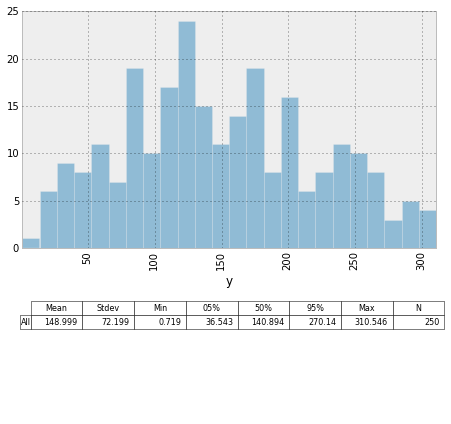

In [3]:
jp.histogram('y', df)

Lets start to visualize how our artifical data looks.  First, plot a histogram of the results.

If you want to look at the data color coded by a categorical variable, you need to specify "legend":

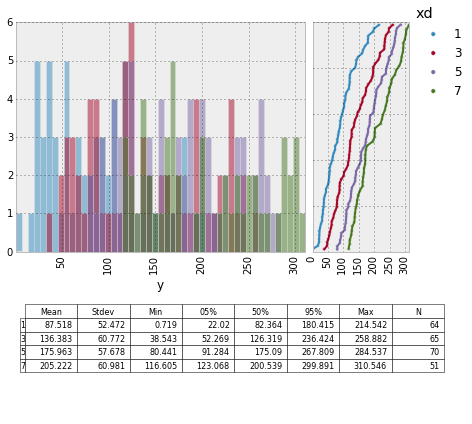

In [4]:
jp.histogram('y', df, legend='xd', bins=50, cumprob=True)

<a id='cumprob'></a>
You can also create cumprob plots:

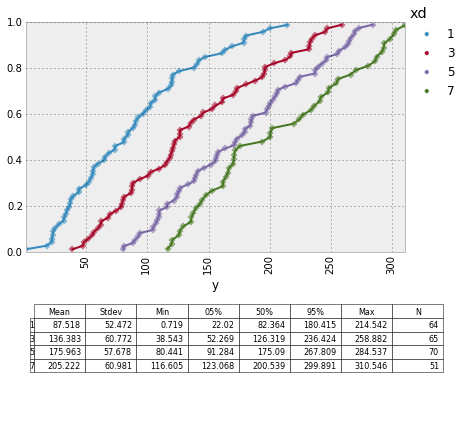

In [5]:
jp.cumprob('y', df, legend='xd', marker='D')

___
<a id='boxplot'></a>
Lets look at the data with a boxplot to see if there is any difference between the groups defined by xd:

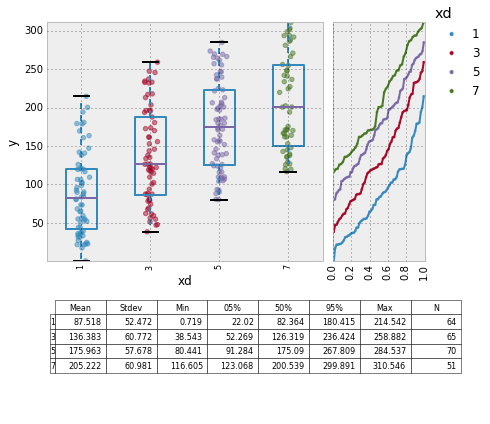

In [6]:
fig = jp.boxplot(x='xd', y='y', data=df, legend='xd', cumprob=True)
fig

___
<a id='scatter'></a>
You can also create a scatter plot with a fit.

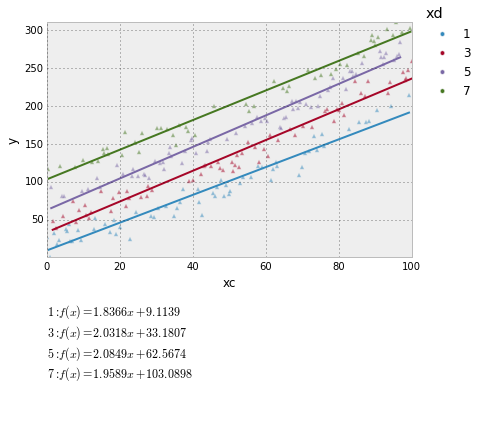

In [7]:
jp.scatter(x='xc', y='y', data=df, legend='xd', fit='linear', marker='^')

We can generate the same graph using the arrays directly without creating the pandas dataframe.  You can fit the data by specifying a fit param.  Currently, linear, quadratic, smooth, and interpolate are supported.

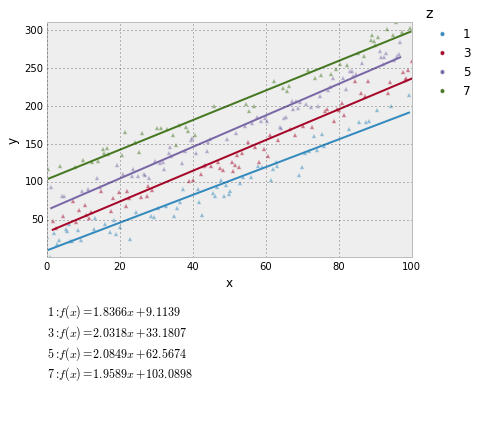

In [8]:
jp.scatter(xc, y=y, legend=xd, fit='linear', marker='^')

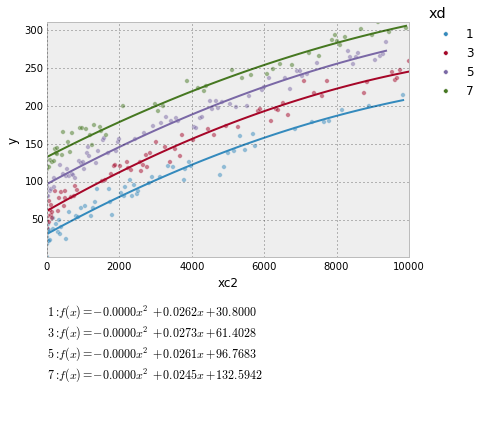

In [9]:
jp.scatter('xc2', 'y', df, legend='xd', fit='quadratic', marker='o')

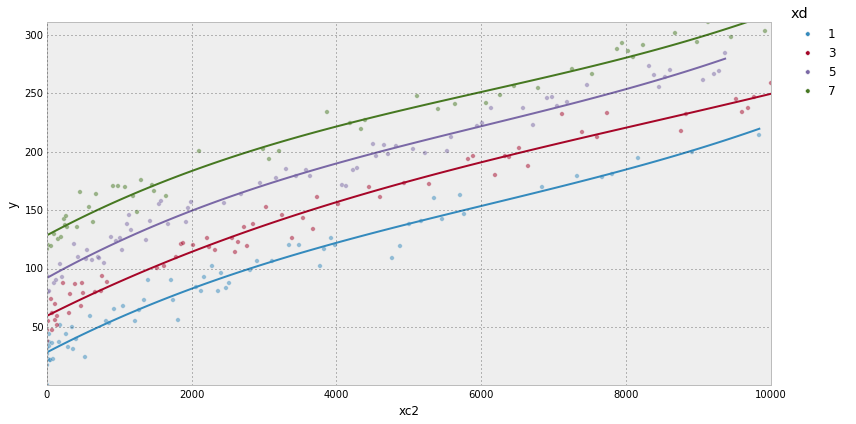

In [10]:
# fitparams get passed into the fitting functions.  Smoothing uses the scipy Univariate spline function.
jp.scatter(x='xc2', y='y', data=df, legend='xd', fit='smooth', fitparams={'s': 1e6})

<a id='contour'></a>
Contour plots can be created as well:

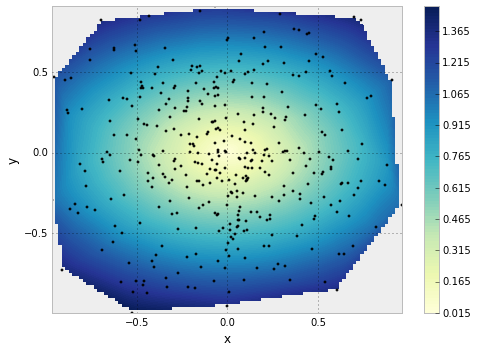

In [11]:
cdf = pd.DataFrame()
x = np.random.triangular(-1, 0, 1, 400)
y = np.random.triangular(-1, 0, 1, 400)
z = np.sqrt(x**2 + 2*y**2)
cdf['x'] = x
cdf['y'] = y
cdf['z'] = z
cdf['Gx'] = np.random.choice(['X1', 'X2'], size=400)
cdf['Gy'] = np.random.choice(['Y1', 'Y2', 'Y3'], size=400)
cdf['Gz'] = np.random.choice(['Z1', 'Z2'], size=400)

jp.contour(x='x', y='y', z='z', data=cdf, cmap='YlGnBu', figsize=(7,5), marker='.')

<a id='grid'></a>
### Grid
JMPY has the capability of creating grids by using the jp.grid function.  You can specify either rows, or columns, or both, and the individual charts will be created with data filtered for the grid.

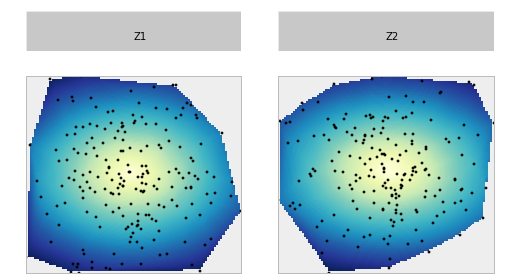

In [12]:
jp.grid(cols='Gz', data=cdf, 
        chart=jp.contour, args={'x':'x', 'y':'y', 'z':'z', 'marker':'.', 'cmap':'YlGnBu', 
                                'axislabels':False, 'axisticks':False},
        figsize=(8, 4),
       )

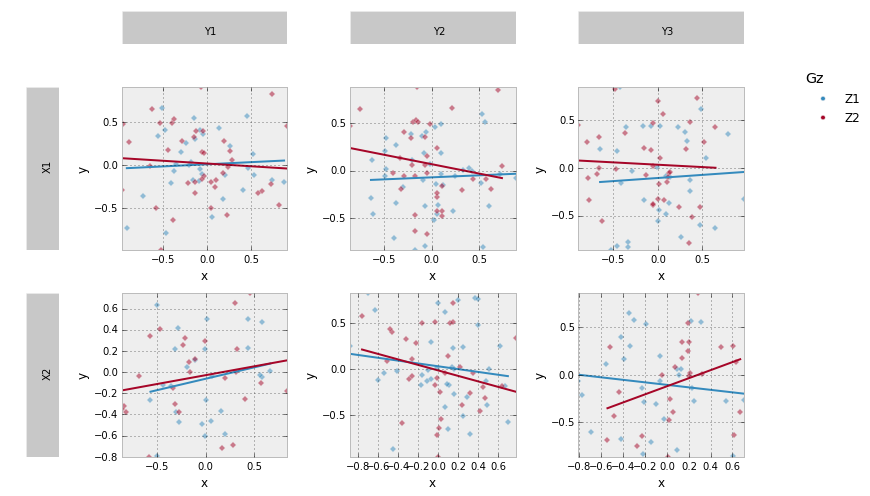

In [13]:
jp.grid(rows='Gx', cols='Gy', data=cdf, 
        chart=jp.scatter, args={'x':'x', 'y':'y', 'marker':'D', 'fit': 'linear'},
        figsize=(12, 7),
        legend='Gz')

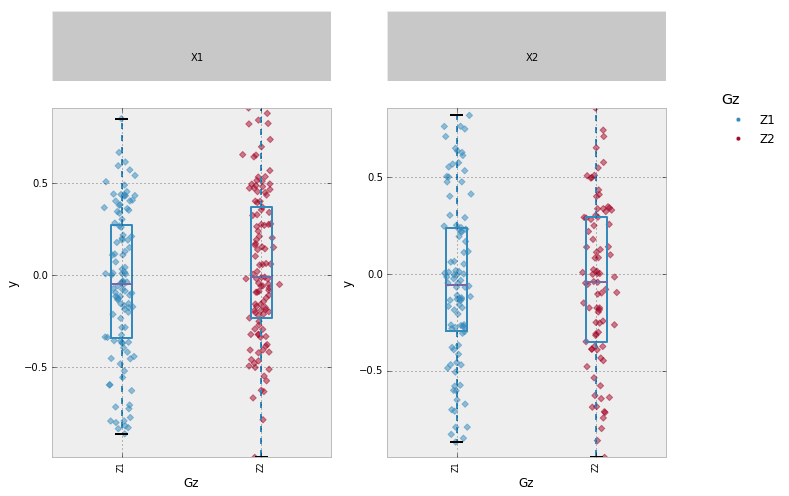

In [14]:
jp.grid(cols='Gx', data=cdf, 
        chart=jp.boxplot, args={'x':'Gz', 'y':'y', 'marker':'D'},
        figsize=(12, 7),
        legend='Gz')

___
<a id='modeling'></a>
### Modeling  
#### Ordinary Least Squares
Now that we have visualized some of the data, lets do some modeling.  jmpy current supports two types of linear modeling:  ordinary least squares and robust linear model, all built on the statsmodels functions.  Lets do the OLS first.  

All models are specified based on the patsy text formulas that are very similar to R.  

By default, only 80% of the data is used to fit the model, and the other 20% is plotted alongside the data to validate the model results.  This can be changed by specifying a different sample_rate parameter.

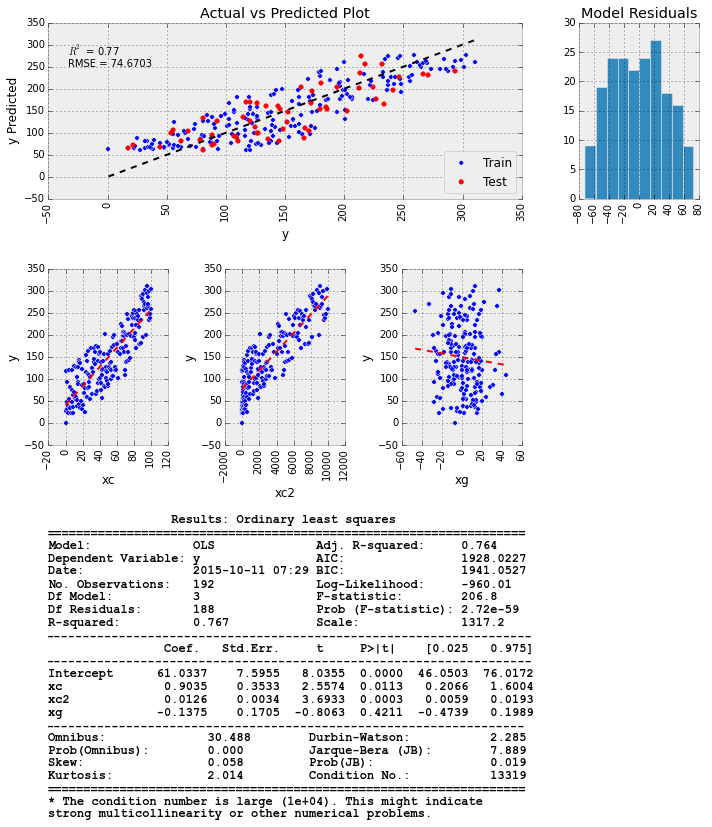

In [15]:
model = 'y ~ xc + xc2 +  xg'
jm.fit(model, data=df, sample_rate=.8, model_type='ols');

___
#### Robust Linear Model
Now... what if we had a couple of outliers in our dataset... lets create some outliers

In [16]:
dfo = df.copy()
p = np.random.uniform(0, 1, size=dfo.y.shape)
err = np.random.normal(size=dfo.y.shape)

dfo['yout'] = dfo.y + np.greater_equal(p, 0.9) * (dfo.y * err)

Our coefficient estimates will be skewed due to the outliers.

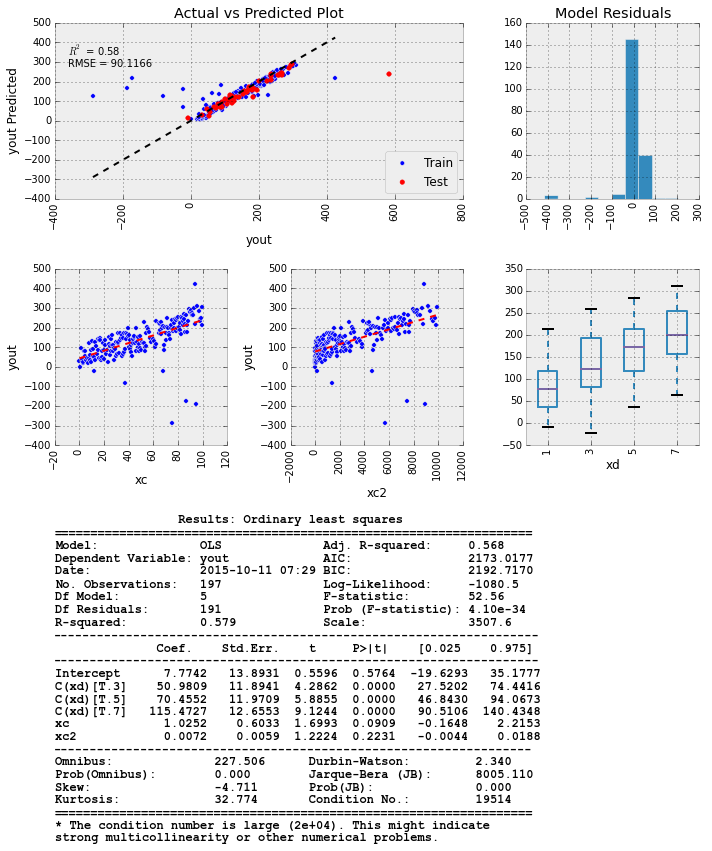

In [17]:
model = 'yout ~ xc + xc2 + C(xd)'
jm.fit(model, data=dfo, sample_rate=.8, model_type='ols');

Employing the robust linear model, we can minimize the influence of the outliers, and get better coefficient predictions.

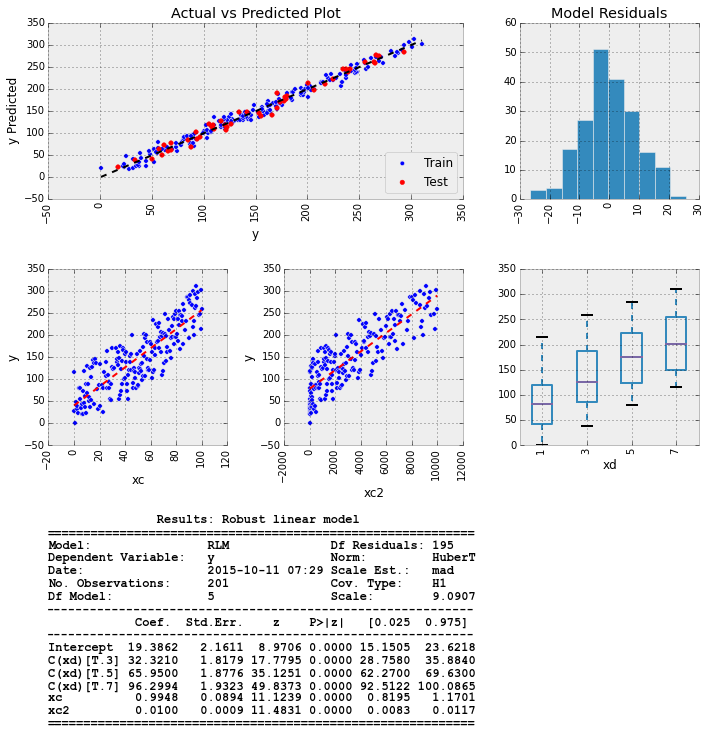

In [18]:
model = 'y ~ xc + xc2 + C(xd)'
jm.fit(model, data=dfo, sample_rate=.8, model_type='rlm');

Our parameter estimates using the robust linear model are much closer to the truth, than using the OLS.

#### Overfitting  
Next we will test how robust the parameter estimates are by running many iterations of the model, and randomly subsetting the data, and then looking at the parameter estimate distributions.

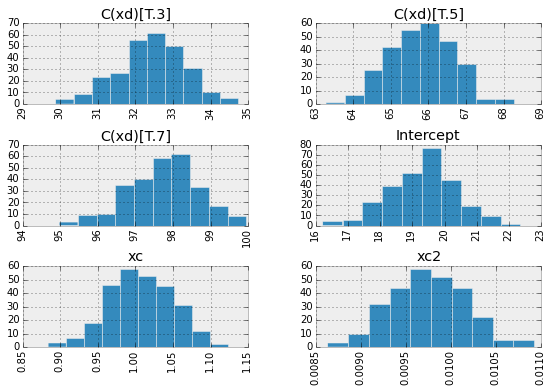

In [19]:
model = 'y ~ xc + xc2 + C(xd)'
jm.check_estimates(model, data=df, sample_rate=.8, model_type='ols', iterations=275);

<a id='bayes'></a>
### Bayesian Oneway Analysis

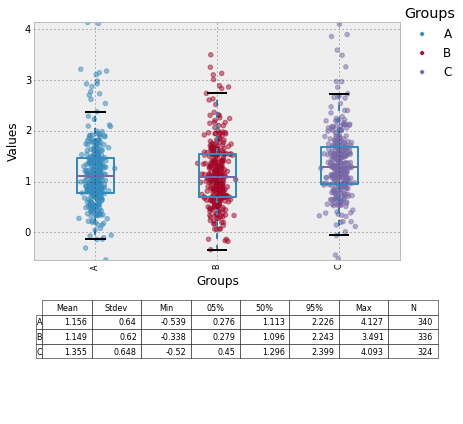

In [20]:
samples = 1000
cats = np.random.choice(('A', 'B', 'C'), size=samples)
avgs = 1.05, 1.1, 1.25
errs = 0.5, 0.5, 0.54
outliers = np.random.choice((0, 2), p=(.95, .05), size=samples)

vals = np.zeros(samples)
for i, t in enumerate(('A', 'B', 'C')):
    err = np.zeros(samples)
    avg = np.zeros(samples)
    err = err + np.random.normal(0, errs[i], size=samples)
    avg = avg + avgs[i]
    vals[cats == t] = avg[cats == t] + err[cats == t] + outliers[cats == t]
    
df = pd.DataFrame()
df['Groups'] = cats
df['Values'] = vals
jp.boxplot('Groups', 'Values', df, legend='Groups')

The bayesian oneway analysis platform returns a result objects after specifying the parameters to be tested.
If you have more than two groups, you need to specify the control group in order to appropriately compare the other groups.  This platform is built on pymc.

In [21]:
res = jb.oneway('Groups', 'Values', df, control='A', iterations=24000, burn=4000, verbose=True)

 [-----------------100%-----------------] 24000 of 24000 complete in 11.6 sec

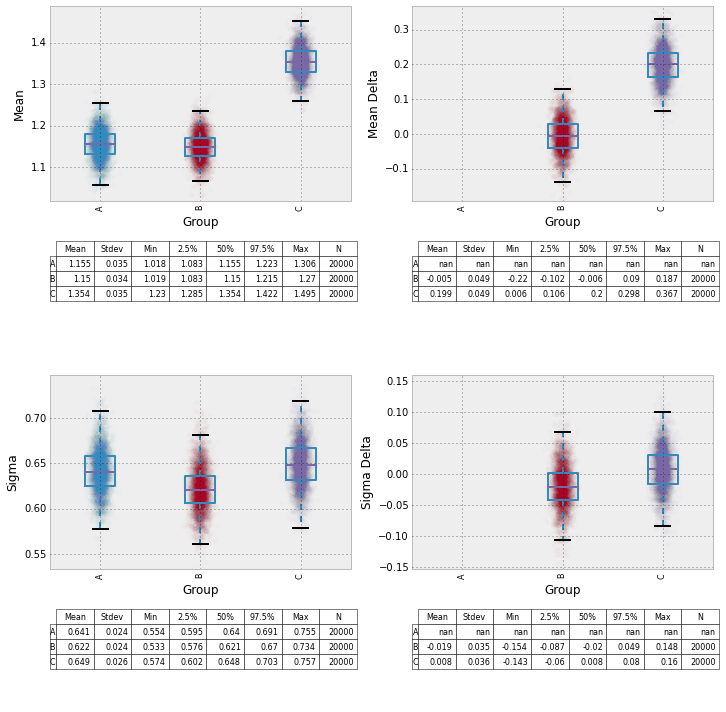

In [22]:
res.result(boxkwargs={'alpha': 0.01, 'points': True}, maxpoints=5000)

Get trace data from the simulation:

Plotting mean_A


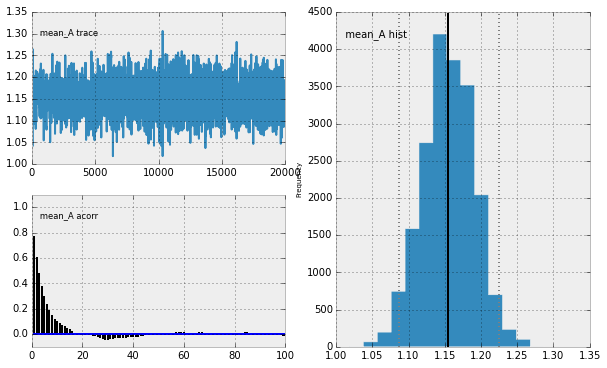

In [23]:
for name in res.names:
    res.traceplot(name)
    break